# Práctica 3 — Lentes delgadas (Análisis de datos)
Este cuaderno reproduce el análisis y las gráficas del reporte: cargas de datos, cómputo de métricas, ajustes en variables inversas, y visualizaciones.  
**Autor:** Alejandro Pérez Romero  
**Lentes:** #13 (positiva), #26 (positiva), #3 (negativa)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reglas: usar matplotlib, una figura por gráfico, sin especificar colores
data_dir = Path('data_practica3')
fig_dir = Path('figs_practica3'); fig_dir.mkdir(exist_ok=True)

def basic_stats(arr):
    arr = np.asarray(arr, dtype=float)
    mean = arr.mean()
    s = arr.std(ddof=1) if len(arr) > 1 else np.nan
    se = s / np.sqrt(len(arr)) if len(arr) > 1 else np.nan
    cv = s / mean * 100 if mean != 0 and not np.isnan(s) else np.nan
    return {"mean": mean, "std": s, "se": se, "cv_pct": cv}

def linear_fit(x, y):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    msk = np.isfinite(x) & np.isfinite(y)
    x = x[msk]; y = y[msk]
    a, b = np.polyfit(x, y, 1)  # y = a*x + b
    y_hat = a*x + b
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
    return a, b, r2

def back_transform_si(so_grid, a, b):
    denom = a*(1/so_grid) + b
    return 1/denom

def f_from_two_positions(D1, D2, d1, d2):
    return (D1*d2 - D2*d1) / (D2 - D1)

## 1) Carga de datos

In [2]:
focal = pd.read_csv(data_dir/'focal_lentes.csv')
amp_26 = pd.read_csv(data_dir/'lente26_objeto_real.csv')
amp_13 = pd.read_csv(data_dir/'lente13_objeto_real.csv')
ivr = pd.read_csv(data_dir/'imagen_virtual_objeto_real.csv')
irov = pd.read_csv(data_dir/'imagen_real_objeto_virtual.csv')
total_L2 = pd.read_csv(data_dir/'L2_todos_los_puntos.csv')

focal, amp_26.head(), amp_13.head()

(   medicion  f_13_cm  f_26_cm
 0         1      7.9     13.8
 1         2      7.8     14.1
 2         3      7.8     14.2,
    so_cm  si_cm  yo_cm  yi_cm   My   Ms  Delta_pct
 0   14.0   72.5    0.6    NaN  NaN -5.2        NaN
 1   28.0   21.8    0.6    0.5 -0.8 -0.8        6.6
 2  100.8   14.3    0.6    NaN  NaN -0.1        NaN
 3   30.8   21.3    0.6    0.6 -1.0 -0.7       30.8
 4   20.8   29.6    0.6    0.9 -1.5 -1.4        5.1,
    so_cm  si_cm  yo_cm  yi_cm   My   Ms  Delta_pct
 0   10.8   26.3    0.6    1.6 -2.7 -2.4       11.1
 1   20.8   11.9    0.6    0.4 -0.7 -0.6       14.5
 2   30.8    9.7    0.6    0.2 -0.3 -0.3       11.7
 3    8.8   49.5    0.6    3.1 -5.2 -5.6        7.7
 4   40.8    9.9    0.6    0.1 -0.2 -0.2       12.0)

## 2) Distancias focales — estadísticas básicas

In [3]:
print('Lente #13:', basic_stats(focal['f_13_cm'].values))
print('Lente #26:', basic_stats(focal['f_26_cm'].values))

Lente #13: {'mean': np.float64(7.833333333333333), 'std': np.float64(0.05773502691896289), 'se': np.float64(0.03333333333333351), 'cv_pct': np.float64(0.7370428968378241)}
Lente #26: {'mean': np.float64(14.033333333333331), 'std': np.float64(0.20816659994661255), 'se': np.float64(0.1201850425154659), 'cv_pct': np.float64(1.4833724461753865)}


## 3) Lente negativa (#3): estimación de $f$

In [4]:
D1, D2, d1, d2 = 7.7, 9.2, 13.2, 17.6
f = f_from_two_positions(D1, D2, d1, d2)
print(f'f (ecuación cerrada) = {f:.3f} cm')

# Monte Carlo con u=0.1 cm
rng = np.random.default_rng(123)
N = 20000; u = 0.1
D1_s = rng.normal(D1, u, N); D2_s = rng.normal(D2, u, N)
d1_s = rng.normal(d1, u, N); d2_s = rng.normal(d2, u, N)
f_s = (D1_s*d2_s - D2_s*d1_s)/(D2_s - D1_s)
print(f'f (Monte Carlo) = {np.mean(f_s):.3f} ± {np.std(f_s, ddof=1):.3f} cm')

f (ecuación cerrada) = 9.387 cm
f (Monte Carlo) = 9.624 ± 2.575 cm


## 4) Lente #26 — $s_i$ vs $s_o$ (todos los puntos)

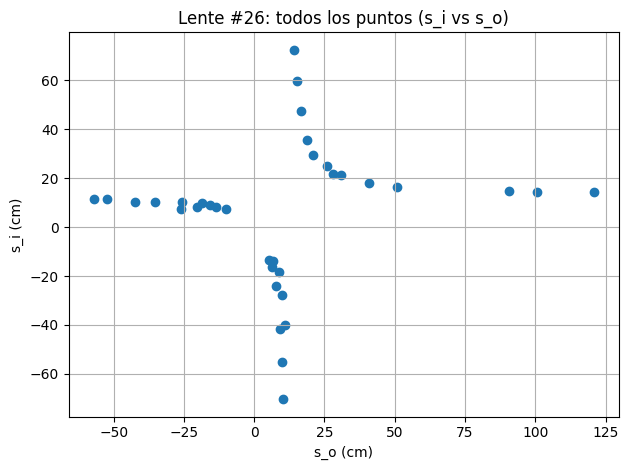

In [5]:
plt.figure()
plt.scatter(total_L2['so_cm'], total_L2['si_cm'])
plt.xlabel('s_o (cm)'); plt.ylabel('s_i (cm)')
plt.title('Lente #26: todos los puntos (s_i vs s_o)')
plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L26_todos_los_puntos.png', dpi=200); plt.show()

## 5) Lente #26 — Ajuste en variables inversas y curva en originales

1/s_i = -0.853*(1/s_o) + 0.070  (R^2=0.964)


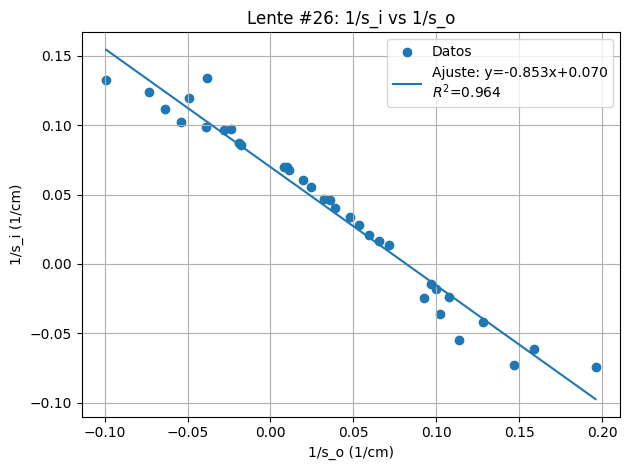

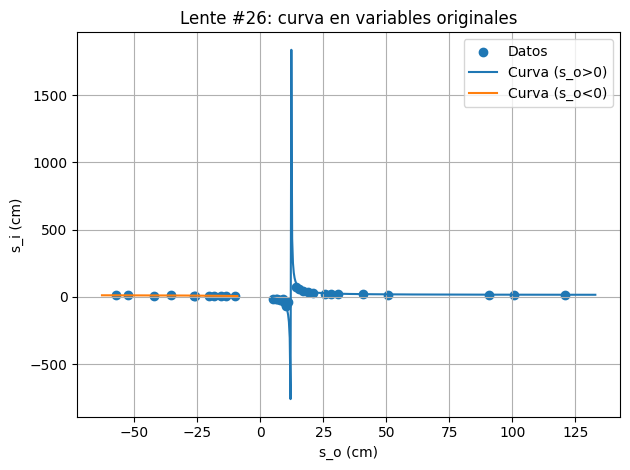

In [6]:
x = 1/total_L2['so_cm'].values
y = 1/total_L2['si_cm'].values
a, b, r2 = linear_fit(x, y)
print(f'1/s_i = {a:.3f}*(1/s_o) + {b:.3f}  (R^2={r2:.3f})')

mask_pos = total_L2['so_cm'] > 0
mask_neg = total_L2['so_cm'] < 0
so_pos_grid = np.linspace(max(1e-3, total_L2.loc[mask_pos, 'so_cm'].min()*0.9),
                          total_L2.loc[mask_pos, 'so_cm'].max()*1.1, 400)
so_neg_grid = np.linspace(total_L2.loc[mask_neg, 'so_cm'].min()*1.1,
                          total_L2.loc[mask_neg, 'so_cm'].max()*0.9, 400)
si_pos = back_transform_si(so_pos_grid, a, b)
si_neg = back_transform_si(so_neg_grid, a, b)

# Inverso
plt.figure()
msk = np.isfinite(x) & np.isfinite(y)
x_line = np.linspace(np.min(x[msk]), np.max(x[msk]), 200)
y_line = a*x_line + b
plt.scatter(x[msk], y[msk], label='Datos')
plt.plot(x_line, y_line, label=f'Ajuste: y={a:.3f}x+{b:.3f}\n$R^2$={r2:.3f}')
plt.xlabel('1/s_o (1/cm)'); plt.ylabel('1/s_i (1/cm)')
plt.title('Lente #26: 1/s_i vs 1/s_o'); plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L26_inverso_ajuste.png', dpi=200); plt.show()

# En originales
plt.figure()
plt.scatter(total_L2['so_cm'], total_L2['si_cm'], label='Datos')
plt.plot(so_pos_grid, si_pos, label='Curva (s_o>0)')
plt.plot(so_neg_grid, si_neg, label='Curva (s_o<0)')
plt.xlabel('s_o (cm)'); plt.ylabel('s_i (cm)')
plt.title('Lente #26: curva en variables originales')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L26_ajuste_en_original.png', dpi=200); plt.show()

## 6) Lente #13 — $s_i$ vs $s_o$ y ajuste inverso

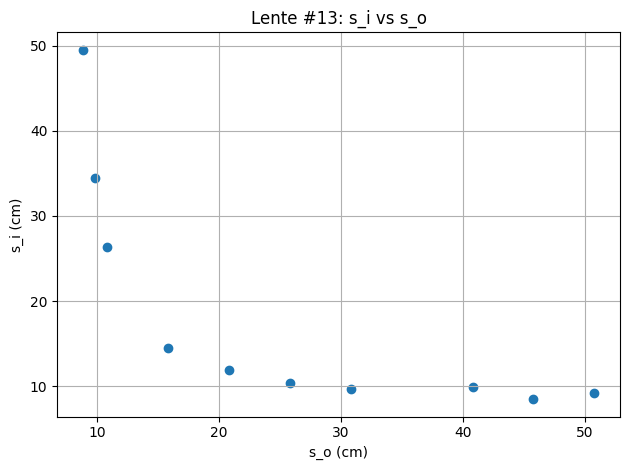

1/s_i = -1.003*(1/s_o) + 0.133  (R^2=0.988)


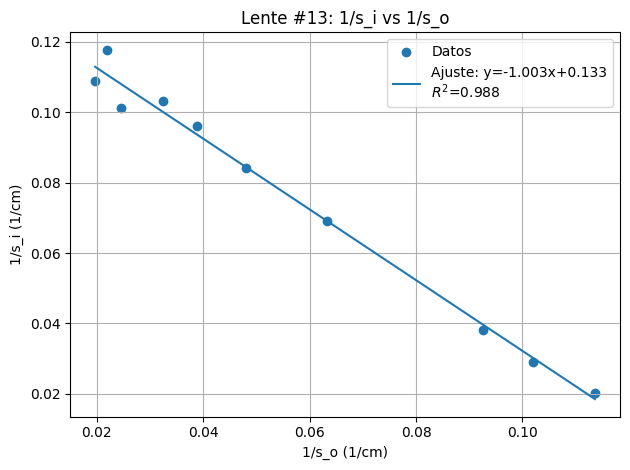

In [7]:
plt.figure()
plt.scatter(amp_13['so_cm'], amp_13['si_cm'])
plt.xlabel('s_o (cm)'); plt.ylabel('s_i (cm)')
plt.title('Lente #13: s_i vs s_o')
plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L13_so_si.png', dpi=200); plt.show()

x13 = 1/amp_13['so_cm'].values
y13 = 1/amp_13['si_cm'].values
a13, b13, r2_13 = linear_fit(x13, y13)
print(f'1/s_i = {a13:.3f}*(1/s_o) + {b13:.3f}  (R^2={r2_13:.3f})')

plt.figure()
msk = np.isfinite(x13) & np.isfinite(y13)
x_line = np.linspace(np.min(x13[msk]), np.max(x13[msk]), 200)
y_line = a13*x_line + b13
plt.scatter(x13[msk], y13[msk], label='Datos')
plt.plot(x_line, y_line, label=f'Ajuste: y={a13:.3f}x+{b13:.3f}\n$R^2$={r2_13:.3f}')
plt.xlabel('1/s_o (1/cm)'); plt.ylabel('1/s_i (1/cm)')
plt.title('Lente #13: 1/s_i vs 1/s_o'); plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L13_inverso_ajuste.png', dpi=200); plt.show()

## 7) Amplificación: $M_y$ vs $M_s$

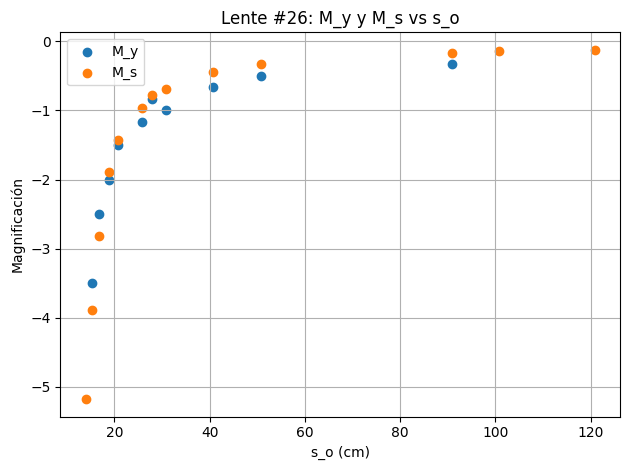

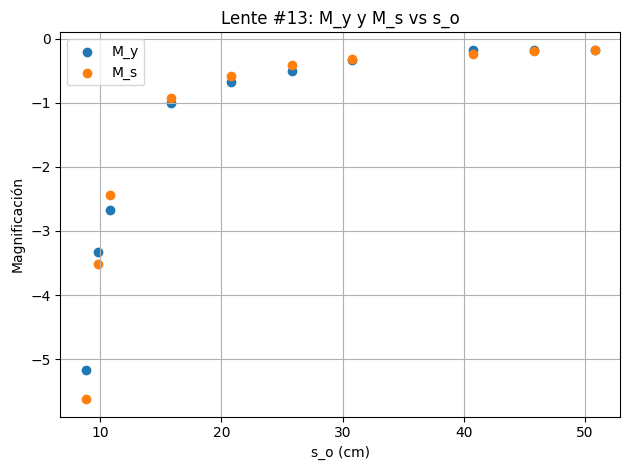

In [8]:
def recompute_metrics(df):
    df = df.copy()
    df['My_recomp'] = np.where(df['yi_cm'].notna() & df['yo_cm'].notna(),
                               -df['yi_cm']/df['yo_cm'], np.nan)
    df['Ms_recomp'] = -df['si_cm']/df['so_cm']
    denom = (df['My_recomp'].abs() + df['Ms_recomp'].abs())/2.0
    df['Delta_pct_sym'] = np.abs(df['My_recomp'].abs() - df['Ms_recomp'].abs())/denom*100
    return df

m26 = recompute_metrics(amp_26)
m13 = recompute_metrics(amp_13)

plt.figure()
mask = m26['My_recomp'].notna()
plt.scatter(m26.loc[mask, 'so_cm'], m26.loc[mask, 'My_recomp'], label='M_y')
plt.scatter(m26['so_cm'], m26['Ms_recomp'], label='M_s')
plt.xlabel('s_o (cm)'); plt.ylabel('Magnificación')
plt.title('Lente #26: M_y y M_s vs s_o')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L26_My_Ms_vs_so.png', dpi=200); plt.show()

plt.figure()
mask = m13['My_recomp'].notna()
plt.scatter(m13.loc[mask, 'so_cm'], m13.loc[mask, 'My_recomp'], label='M_y')
plt.scatter(m13['so_cm'], m13['Ms_recomp'], label='M_s')
plt.xlabel('s_o (cm)'); plt.ylabel('Magnificación')
plt.title('Lente #13: M_y y M_s vs s_o')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'L13_My_Ms_vs_so.png', dpi=200); plt.show()

## 8) Sistemas de dos lentes

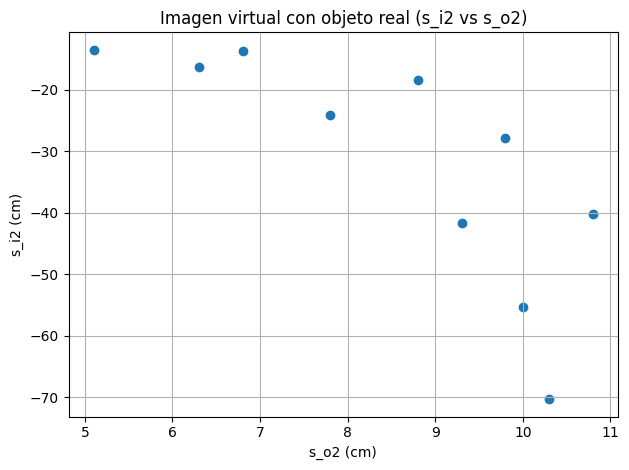

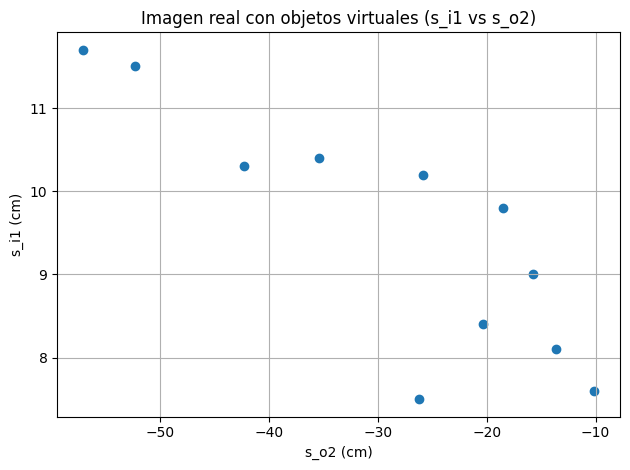

In [9]:
# Imagen virtual con objeto real (s_o2 vs s_i2)
plt.figure()
plt.scatter(ivr['so2_cm'], ivr['si2_cm'])
plt.xlabel('s_o2 (cm)'); plt.ylabel('s_i2 (cm)')
plt.title('Imagen virtual con objeto real (s_i2 vs s_o2)')
plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'so2_si2_scatter.png', dpi=200); plt.show()

# Imagen real con objetos virtuales (s_o2 vs s_i1)
plt.figure()
plt.scatter(irov['so2_cm'], irov['si1_cm'])
plt.xlabel('s_o2 (cm)'); plt.ylabel('s_i1 (cm)')
plt.title('Imagen real con objetos virtuales (s_i1 vs s_o2)')
plt.grid(True); plt.tight_layout()
plt.savefig(fig_dir/'imagenreal_objetovirtual_scatter.png', dpi=200); plt.show()